['PEP', 'KO']


[*********************100%%**********************]  1 of 1 completed


Data for PEP saved to SA15\PEP_adjusted_close_data.csv


[*********************100%%**********************]  1 of 1 completed


Data for KO saved to SA15\KO_adjusted_close_data.csv
Empty DataFrame
Columns: [Date, Pair, Trade_Type, Quantity_Stock1, Entry_Price_Stock1, Exit_Price_Stock1, Quantity_Stock2, Entry_Price_Stock2, Exit_Price_Stock2, Spread, Hedge_Ratio]
Index: []
All pairs tested for cointegration and their ADF test results:
{'pair': ('KO', 'PEP'), 'hedge_ratio': 0.2911730163066372, 'adf_statistic': -3.2527630562307777, 'p_value': 0.01712660550888531, 'critical_values': {'1%': -3.4365224825380714, '5%': -2.86426535058257, '10%': -2.568221078163292}, 'is_cointegrated': True}

Cointegrated pairs:
('KO', 'PEP')


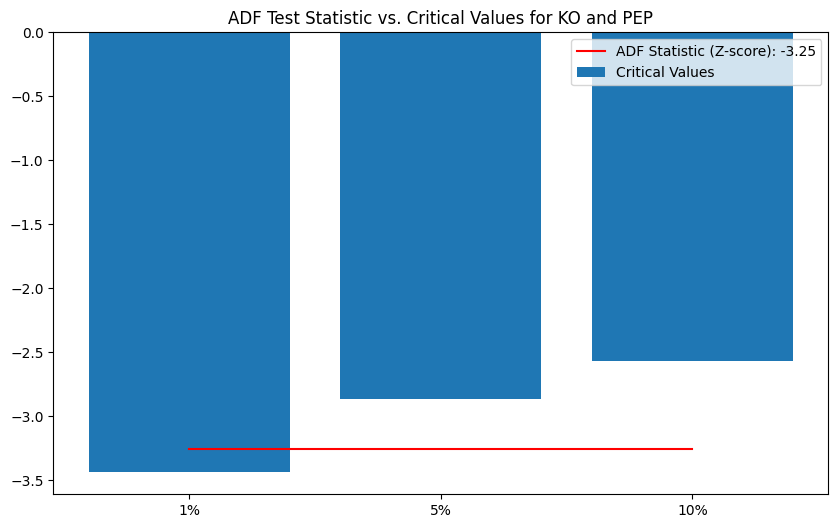

In [2]:
# Import necessary libraries and modules for various tasks:
# os for operating system interaction, pandas for data manipulation, itertools for efficient looping,
# statsmodels for statistical models, sklearn for machine learning, keras for neural networks,
# numpy for numerical operations, yfinance for financial data download, matplotlib.pyplot for plotting,
# and sklearn for additional machine learning utilities.
import os
import pandas as pd
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn


# Define a list of ticker symbols for the currency pairs we are interested in analyzing. These are Forex pairs.
tickers = ['PEP', 'KO']

# Print the list of tickers to verify that they are defined correctly. This is a basic debugging step.
print(tickers)

# Specify the start and end dates for downloading historical data from Yahoo Finance.
start_date = '2020-01-01'
end_date = '2024-04-11'

# Create a directory to store the downloaded CSV files. If the directory doesn't exist, it will be created.
# This ensures that your data is organized and stored in a specific location.
folder_name = 'SA15'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


# Iterate over each ticker symbol in the 'tickers' list to download and save its historical data.
for ticker in tickers:
    # Download the historical data for the specified ticker between the start and end dates.
    # We're specifically interested in the 'Adjusted Close' prices.
    data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    # Remove any missing values (NaNs) from the data to ensure clean data for analysis.
    data.dropna(inplace=True)
    # Construct the file path where the data will be saved, using the folder name and ticker symbol.
    file_path = os.path.join(folder_name, f'{ticker}_adjusted_close_data.csv')
    # Save the downloaded data to a CSV file at the specified file path.
    data.to_csv(file_path)
    # Print a message confirming that the data has been saved successfully.
    print(f'Data for {ticker} saved to {file_path}')



# Initialize an empty dictionary to store DataFrames for each ticker symbol.
dataframes = {}
# List all CSV files in the specified folder that end with '.csv'. This is done using list comprehension.
csv_files = [f for f in os.listdir(folder_name) if f.endswith('.csv')]
# Iterate over each CSV file, loading its contents into a DataFrame and storing it in the 'dataframes' dictionary.
for file in csv_files:
    # Extract the ticker symbol from the file name by removing the suffix.
    ticker = file.replace('_adjusted_close_data.csv', '')
    # Load the CSV file as a DataFrame, setting the 'Date' column as the index and parsing it as dates.
    df = pd.read_csv(os.path.join(folder_name, file), index_col='Date', parse_dates=True)
    # Store the DataFrame in the 'dataframes' dictionary using the ticker symbol as the key.
    dataframes[ticker] = df['Adj Close']

# Initialize an empty DataFrame for recording trades. The columns include various details about each trade,
# such as date, pair involved in the trade, trade type, quantities of each stock, entry and exit prices,
# spread, and hedge ratio. This structured format will help in analyzing and tracking trade performance.
trades_df = pd.DataFrame(columns=[
    'Date', 'Pair', 'Trade_Type', 'Quantity_Stock1', 'Entry_Price_Stock1', 'Exit_Price_Stock1',
    'Quantity_Stock2', 'Entry_Price_Stock2', 'Exit_Price_Stock2', 'Spread', 'Hedge_Ratio'
])
# Print the empty trades DataFrame to verify its structure. This is helpful for debugging and ensuring
# that the DataFrame is initialized correctly before adding any trade data to it.
print(trades_df)

# This function is designed to fetch the most recent (latest) price for a specified financial instrument (e.g., stock, currency pair) based on its ticker symbol.
def get_current_price(ticker):
    # Constructs the file path where the historical data of the specified ticker is stored. The directory 'SAR3' is prefixed to the filename, which is expected to follow the pattern '{ticker}_adjusted_close_data.csv'.
    file_path = os.path.join('SAR3', f'{ticker}_adjusted_close_data.csv')
    
    # Checks if the constructed file path exists in the file system. If the file does not exist, an error message is printed, and the function returns None. This serves as a basic error handling mechanism to avoid attempting to read a non-existent file.
    if not os.path.exists(file_path):
        print(f"Error: Data file for {ticker} does not exist.")
        return None
    
    # If the file exists, it's loaded into a pandas DataFrame. The 'Date' column is used as the index, and it's parsed as date objects for easier manipulation of time series data.
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    # Retrieves the most recent (last) 'Adj Close' price from the DataFrame. '.iloc[-1]' is used to select the last row of the 'Adj Close' column.
    current_price = df['Adj Close'].iloc[-1]
    
    # Returns the fetched current price.
    return current_price


# Utilizes itertools.combinations to generate all possible unique pairs (combinations) of assets (e.g., stocks, currency pairs) from the keys of the 'dataframes' dictionary. Each asset is represented by its ticker symbol.
pairs = combinations(dataframes.keys(), 2)


# Initializes an empty list named 'cointegration_results'. This list will later be populated with the results of cointegration tests performed on each pair of assets identified above.
cointegration_results = []

# Iterates over each unique pair of assets generated in the 'pairs' variable.
for stock1, stock2 in pairs:
    # Merges the DataFrames corresponding to each asset in the pair into a single DataFrame. The merge is performed on their indexes (dates), ensuring that only dates present in both DataFrames are included. The suffixes '_x' and '_y' are added to columns of the first and second DataFrames, respectively, to distinguish them after merging.
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    # Removes any rows that contain NaN values from the merged DataFrame. This step ensures that the data is clean and suitable for statistical analysis.
    merged_df.dropna(inplace=True)
    
    # Checks if the merged DataFrame contains at least 20 rows of data. This arbitrary threshold ensures there's enough data to perform meaningful cointegration analysis. If there isn't sufficient data, the loop continues to the next pair without performing any further actions on the current pair.
    if len(merged_df) < 20:
        continue


# Add a column of ones to serve as the intercept term in the linear model. This is necessary for OLS regression in statsmodels.
X = sm.add_constant(merged_df.iloc[:, 1])
# Perform Ordinary Least Squares (OLS) regression using 'sm.OLS'. The dependent variable (y) is the first column of 'merged_df', representing the price series of the first stock. The independent variable(s) (X) includes the constant and the price series of the second stock.
model = sm.OLS(merged_df.iloc[:, 0], X).fit()
# Extract the hedge ratio from the model's parameters. The hedge ratio is the coefficient of the second stock's price series, indicating how much of the second stock is needed to hedge against price movements in the first stock.
hedge_ratio = model.params.iloc[1]


# Calculate the spread by subtracting the hedge ratio times the price series of the second stock from the price series of the first stock. This spread represents the difference in value adjusted for the hedge ratio, often used in pairs trading strategies.
spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]


# Perform the Augmented Dickey-Fuller (ADF) test on the calculated spread to test for stationarity. A stationary spread implies that the pair of stocks is cointegrated.
adf_result = adfuller(spread)


# Append a dictionary with key results from the cointegration analysis to the 'cointegration_results' list. This dictionary includes: the pair of stocks, hedge ratio, ADF test statistic, p-value from the ADF test, critical values at different confidence levels, and a boolean indicating whether the pair is considered cointegrated based on a 5% significance level.
cointegration_results.append({
    'pair': (stock1, stock2),
    'hedge_ratio': hedge_ratio,
    'adf_statistic': adf_result[0],
    'p_value': adf_result[1],
    'critical_values': adf_result[4],
    'is_cointegrated': adf_result[1] < 0.05  # Using a 5% significance level to determine cointegration.
})

# Print a header line for clarity in output.
print("All pairs tested for cointegration and their ADF test results:")
# Iterate over each result in 'cointegration_results' and print it. This provides an overview of all tested pairs and their respective ADF test outcomes.
for result in cointegration_results:
    print(result)


# Filter 'cointegration_results' to only include pairs where 'is_cointegrated' is True, indicating that the pair passed the cointegration test at a 5% significance level.
cointegrated_pairs = [result for result in cointegration_results if result['is_cointegrated']]

# Print a header line for clarity, followed by each cointegrated pair. This highlights which pairs are potentially suitable for pairs trading strategies based on cointegration criteria.
print("\nCointegrated pairs:")
for pair in cointegrated_pairs:
    print(pair['pair'])

# Define a function named 'prepare_data' to format the input data for training an LSTM (Long Short-Term Memory) model.
def prepare_data(data, lookback):
    # Initialize two empty lists: 'X' for storing input sequences and 'y' for storing the corresponding target values.
    X, y = [], []
    # Loop through the 'data' array. The range is set so that there's enough data after the current index to form a full sequence based on 'lookback' plus one more data point to use as the target value.
    for i in range(len(data) - lookback - 1):
        # Append a slice of 'data' from the current index 'i' up to 'i + lookback' to 'X'. This slice represents a sequence of data points used as input to the LSTM.
        X.append(data[i:(i + lookback)])
        # Append the data point immediately following the current sequence to 'y'. This is the target value that the LSTM model will be trained to predict.
        y.append(data[i + lookback])
    # Convert the lists 'X' and 'y' into numpy arrays, which are more suitable for machine learning tasks, and return them.
    return np.array(X), np.array(y)

# Iterate over each result in 'cointegration_results', a list containing results from cointegration tests performed on pairs of assets.
for result in cointegration_results:
    # Extract relevant information from each 'result' dictionary: the pair of assets, the ADF (Augmented Dickey-Fuller) test statistic, and critical values for determining cointegration.
    pair = result['pair']
    adf_statistic = result['adf_statistic']
    critical_values = result['critical_values']

    # Create a new figure for plotting with a size of 10x6 inches. This provides a canvas on which to draw the subsequent plot.
    plt.figure(figsize=(10, 6))
    # Plot a bar chart where each bar represents a critical value from the ADF test. The x-axis positions are determined by enumerating the critical values, and the heights of the bars are the values themselves.
    plt.bar(range(len(critical_values)), list(critical_values.values()), label='Critical Values')
    # Plot a horizontal line representing the ADF test statistic across the first three x-axis positions. This visually compares the test statistic to the critical values. The line is colored red and labeled with the test statistic value.
    plt.plot([0, 1, 2], [adf_statistic, adf_statistic, adf_statistic], label=f'ADF Statistic (Z-score): {adf_statistic:.2f}', color='r')
    # Set custom tick labels on the x-axis using the keys from 'critical_values', which typically represent different confidence levels (e.g., "1%", "5%", "10%").
    plt.xticks(range(len(critical_values)), labels=critical_values.keys())
    # Set a title for the plot that includes the pair of assets being analyzed. This provides context for interpreting the plot.
    plt.title(f'ADF Test Statistic vs. Critical Values for {pair[0]} and {pair[1]}')
    # Add a legend to the plot, which helps explain the meaning of the bars and the horizontal line.
    plt.legend()
    # Display the plot. This command renders the figure and shows it to the user, providing visual insights into whether each pair of assets is cointegrated based on their ADF test results.
    plt.show()


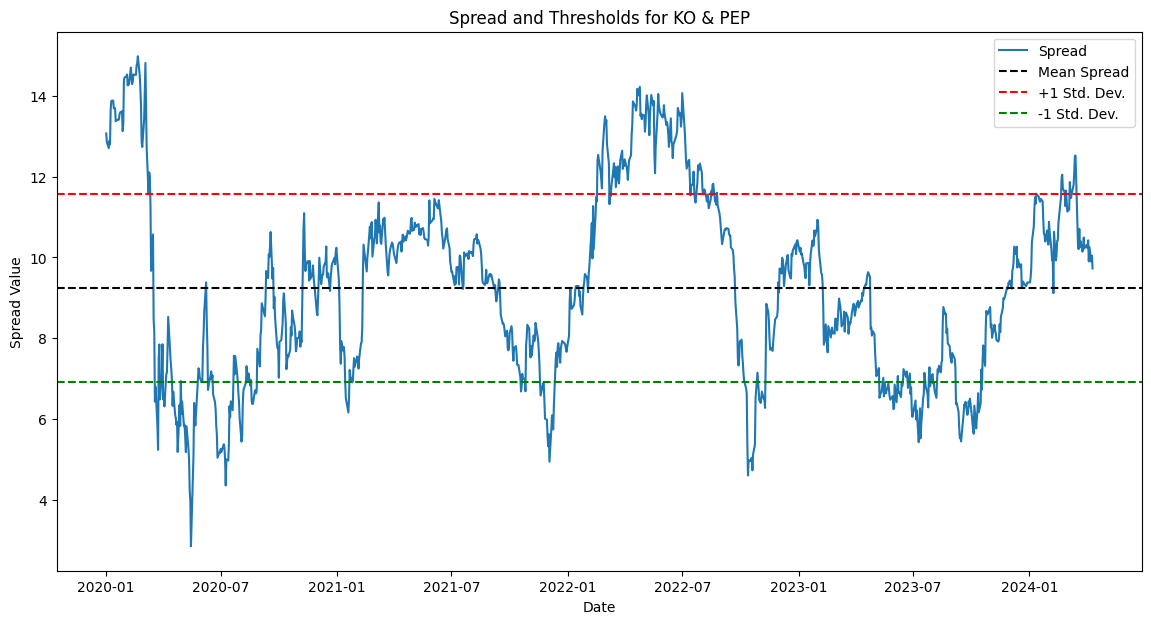

In [3]:
# Iterate over each pair that has been identified as cointegrated based on previous analysis
for result in cointegrated_pairs:
    # Extract the asset pair and the hedge ratio from the result dictionary
    stock1, stock2 = result['pair']
    hedge_ratio = result['hedge_ratio']
    
    # Merge the price data of the two stocks into a single DataFrame based on their indexes.
    # This allows for a direct comparison of their prices over time.
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    
    # Calculate the spread between the two assets. The spread is the price of the first asset minus
    # the price of the second asset adjusted by the hedge ratio. The hedge ratio is used to scale
    # the prices of the second asset to match the scale of the first, aiming to neutralize market exposure.
    spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]
    
    # Calculate the mean of the spread. This represents the average difference between the scaled prices
    # of the two assets over the observed period and serves as a baseline to identify significant deviations.
    mean_spread = np.mean(spread)
    
    # Calculate the standard deviation of the spread. This measures how much variation or dispersion exists
    # from the mean spread. A higher standard deviation indicates a wider range of values that the spread can take.
    std_spread = np.std(spread)
    
    # Begin plotting the spread and its statistical thresholds.
    plt.figure(figsize=(14, 7))  # Set the size of the plot.
    
    # Plot the spread over time. This line represents the changing difference between the scaled prices
    # of the two assets throughout the observed period.
    plt.plot(spread.index, spread, label='Spread')
    
    # Plot a horizontal line at the mean spread. This line serves as a reference point to identify when
    # the spread is deviating from its average value.
    plt.axhline(mean_spread, color='black', linestyle='--', label='Mean Spread')
    
    # Plot horizontal lines one standard deviation above and below the mean spread. These lines represent
    # thresholds for potentially significant deviations from the mean. Crossing these thresholds might trigger
    # trading signals in a pairs trading strategy.
    plt.axhline(mean_spread + std_spread, color='red', linestyle='--', label='+1 Std. Dev.')
    plt.axhline(mean_spread - std_spread, color='green', linestyle='--', label='-1 Std. Dev.')
    
    # Add titles and labels to make the plot informative.
    plt.title(f'Spread and Thresholds for {stock1} & {stock2}')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    
    # Display a legend to identify each component of the plot.
    plt.legend()
    
    # Render the plot to display it.
    plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Results:
        pair  train_rmse  test_rmse
0  (KO, PEP)    0.599298   0.563724


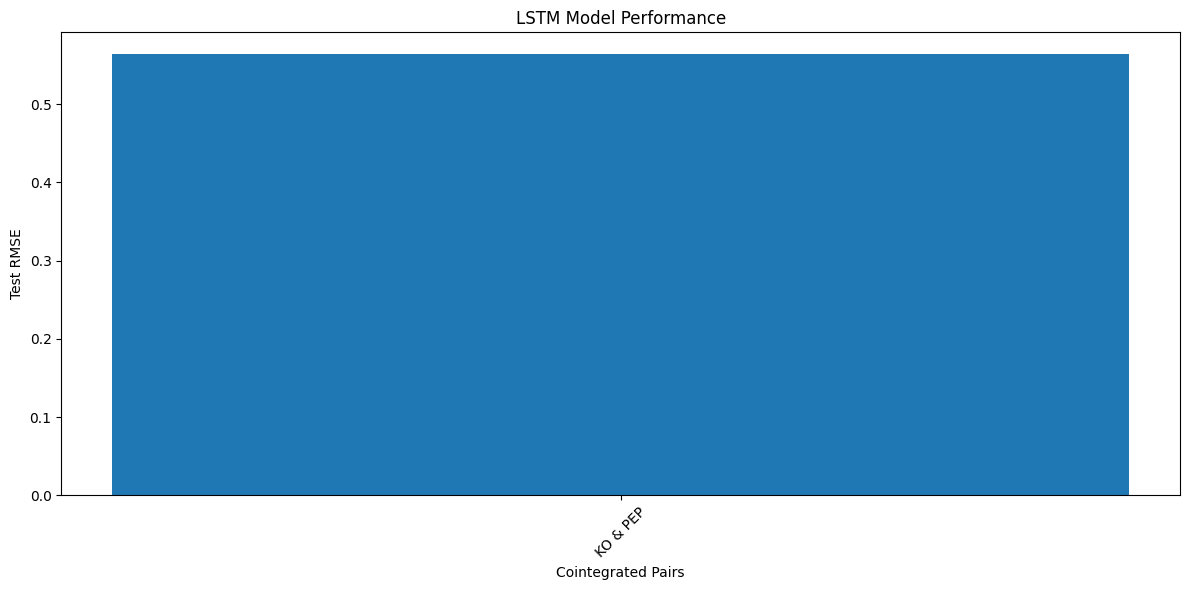

In [4]:
# Initialize an empty list named 'lstm_results'. This list will store the results or outputs after training the LSTM model for each pair of cointegrated stocks or assets.
lstm_results = []

# Loop through each result in 'cointegrated_pairs'. Each 'result' contains information about a pair of cointegrated stocks, including their tickers and hedge ratio.
for result in cointegrated_pairs:
    # Extract the ticker symbols of the two stocks from each 'result' dictionary.
    stock1, stock2 = result['pair']

    # Merge the dataframes of the two stocks on their indexes, which allows for the alignment of dates. This is crucial for calculating the spread accurately.
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    # Calculate the spread by subtracting the hedge ratio adjusted price of 'stock2' from 'stock1'. This spread is what we aim to predict using the LSTM model.
    spread = merged_df.iloc[:, 0] - result['hedge_ratio'] * merged_df.iloc[:, 1]

    # Initialize the MinMaxScaler. This scaler adjusts the spread values to a specified range (0, 1), which helps in speeding up the convergence of neural networks by normalizing the input features.
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit and transform the spread data with the scaler. The 'reshape(-1, 1)' is necessary because 'fit_transform' expects a 2D array.
    spread_scaled = scaler.fit_transform(spread.values.reshape(-1, 1))
    # Define 'lookback', which is the number of past time steps to use as input variables to predict the next time period — in this case, set to 60.
    lookback = 60
    # Define 'embargo_period', a gap period to avoid lookahead bias by excluding recent data points from the training set.
    embargo_period = 5
    # Define 'purge_period', which is used to further mitigate potential lookahead bias by creating a buffer zone between training and test sets.
    purge_period = 5


    # Calculate the starting index for the test set by taking 80% of the scaled spread's length and adding the embargo period to it. 
    #This ensures that the test set begins after leaving out recent data points post-training set.
    test_start_index = int(len(spread_scaled) * 0.8) + embargo_period

    # Utilize the previously defined 'prepare_data' function to create input (X) and output (y) datasets for the LSTM model, based on the scaled spread data and lookback period.
    X, y = prepare_data(spread_scaled, lookback)

    # Calculate the total size of dataset available for splitting into training and test sets.
    total_size = len(X)
    # Calculate the size of the training set as 80% of the total dataset size.
    train_size = int(total_size * 0.8)
    # Calculate 'purge_index' to adjust the end of the training set by subtracting 'purge_period', creating a buffer zone before starting the test set to avoid leakage.
    purge_index = train_size - purge_period
    # Calculate 'embargo_index' to adjust the start of the test set by adding 'embargo_period', ensuring a gap after the training set ends.
    embargo_index = train_size + embargo_period
    # Splits the prepared dataset into training and test sets. The split accounts for 'purge' and 'embargo' periods to prevent look-ahead bias and ensure that the model is tested on unseen data.
    X_train, X_test = X[:purge_index], X[embargo_index:]
    y_train, y_test = y[:purge_index], y[embargo_index:]

    # Initializes the Sequential model from Keras, which allows us to build a model layer by layer.
    model = Sequential()
    # Adds an input layer that specifies the shape of input data. The 'lookback' variable defines the number of time steps to look back.
    model.add(Input(shape=(lookback, 1)))
    # Adds an LSTM layer with 30 units (neurons). This is the core of the LSTM model where temporal dependencies are learned.
    model.add(LSTM(30))
    # Adds a Dense layer with a single neuron for output since we're forecasting a single value.
    model.add(Dense(1))
    # Compiles the model using 'adam' optimizer and mean squared error as the loss function. This setup is common for regression problems.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fits the model to the training data. 'epochs' specifies how many times the learning algorithm will work through the entire training dataset. 'batch_size' is the number of samples per gradient update. 
    #'verbose=0' means no output will be shown during training. Validation data is also provided to monitor the model's performance on unseen data.
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, validation_data=(X_test, y_test))

    # Uses the trained model to make predictions on the training and test sets. Then, it inversely transforms the predictions and actual values back to their original scale using 'scaler'.
    train_predict = scaler.inverse_transform(model.predict(X_train))
    test_predict = scaler.inverse_transform(model.predict(X_test))
    # Calculates the Root Mean Squared Error (RMSE) for both training and test predictions. RMSE is a common measure of accuracy for continuous variables.
    train_rmse = np.sqrt(np.mean((scaler.inverse_transform(y_train.reshape(-1, 1)) - train_predict)**2))
    test_rmse = np.sqrt(np.mean((scaler.inverse_transform(y_test.reshape(-1, 1)) - test_predict)**2))
    # Appends a dictionary containing the pair of stocks, training RMSE, and test RMSE to 'lstm_results'. This allows for performance tracking across different cointegrated pairs.
    lstm_results.append({
        'pair': (stock1, stock2),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

# Display LSTM model results
lstm_results_df = pd.DataFrame(lstm_results)
print("LSTM Model Results:")
print(lstm_results_df.sort_values(by='test_rmse'))

# Visualize the LSTM model results
plt.figure(figsize=(12, 6))
plt.bar(range(len(lstm_results_df)), lstm_results_df['test_rmse'])
plt.xticks(range(len(lstm_results_df)), [f'{pair[0]} & {pair[1]}' for pair in lstm_results_df['pair']], rotation=45)
plt.xlabel('Cointegrated Pairs')
plt.ylabel('Test RMSE')
plt.title('LSTM Model Performance')
plt.tight_layout()
plt.show()

In [6]:
trades_df = pd.DataFrame(columns=['Date', 'Pair', 'Trade_Type', 'Quantity_Stock1', 'Price_Stock1', 'Quantity_Stock2', 'Price_Stock2', 'Spread'])

print(trades_df)

Empty DataFrame
Columns: [Date, Pair, Trade_Type, Quantity_Stock1, Price_Stock1, Quantity_Stock2, Price_Stock2, Spread]
Index: []


         Date       Trade     Spread
0  2020-03-10    Go Short  12.102384
1  2020-03-17  Exit Short   8.460369
2  2020-03-19     Go Long   6.434093
3  2020-06-08   Exit Long   9.384236
4  2020-06-11     Go Long   6.722591
5  2020-09-11   Exit Long   9.663399
6  2021-01-14     Go Long   6.897379
7  2021-02-11   Exit Long   9.671194
8  2021-10-19     Go Long   6.684800
9  2022-01-14   Exit Long   9.291324
10 2022-02-17    Go Short  12.405385
11 2022-09-23  Exit Short   8.915624
12 2022-10-10     Go Long   6.765676
13 2022-11-30   Exit Long   9.387777
14 2023-05-09     Go Long   6.528059
15 2023-11-27   Exit Long   9.266966
16 2024-01-12    Go Short  11.575140
17 2024-02-08  Exit Short   9.118178
18 2024-02-21    Go Short  11.967608


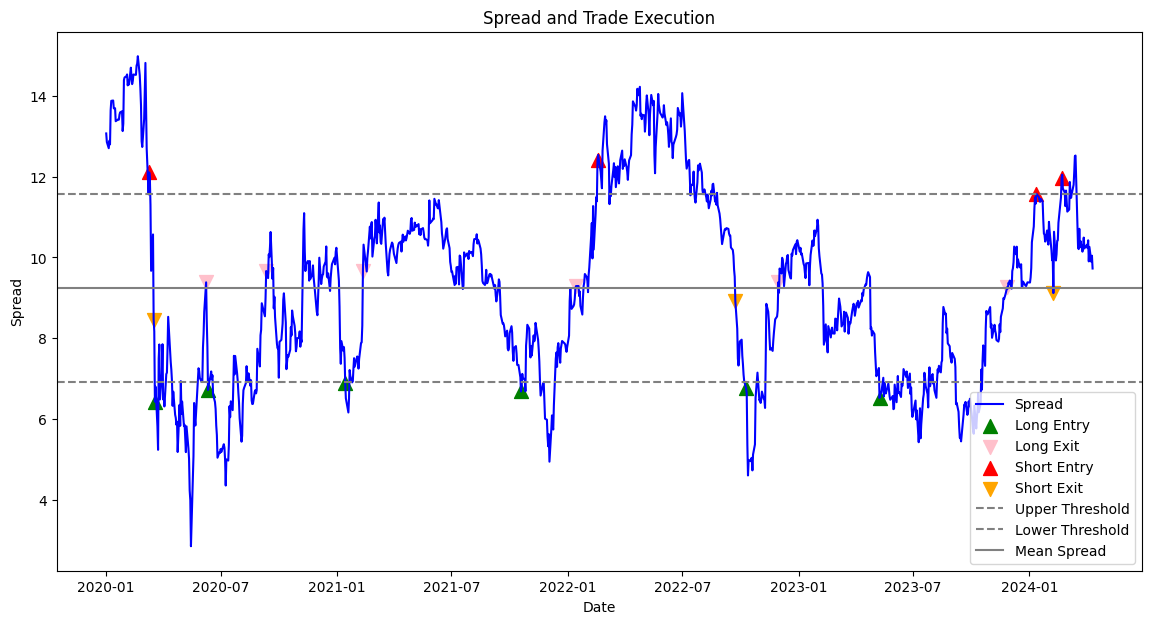

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize position tracking with 'None'. 
#This variable will later be used to track whether the trading strategy is currently holding a 'Long' or 'Short' position, or if it's out of the market (None).
current_position = None  # Possible values: None, 'Long', 'Short'


# Calculate the spread between two financial instruments. 
#The spread is computed as the price of the first instrument minus the hedge ratio times the price of the second instrument. 
#This spread will be used to identify trading opportunities.
spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]

# Calculate the mean (average) value of the spread. This serves as a central tendency measure around which trading decisions can be made.
mean_spread = spread.mean()

# Calculate the standard deviation of the spread, which measures how much variation or dispersion from the average exists.
#This is used to set dynamic thresholds for trade entry and exit.
std_spread = spread.std()

# Define entry and exit thresholds for trading. 
#The upper threshold is set one standard deviation above the mean spread, and the lower threshold is set one standard deviation below it.
#These thresholds help in determining when to enter or exit trades based on the spread's deviation from its mean.
upper_threshold = mean_spread + std_spread
lower_threshold = mean_spread - std_spread

# Initialize an empty list to keep track of trades made by the strategy.
#Each trade can be recorded as a dictionary or any other suitable data structure within this list.
trades = []


# Iterate over the spread data starting from the second element (index 1) since we compare each point with its predecessor.
for i in range(1, len(spread)):
    
    # Go long (buy A, sell B)
    # if the previous spread is above the lower threshold and the current spread drops below it, and we're not already in a position.
    if spread.iloc[i-1] > lower_threshold and spread.iloc[i] <= lower_threshold and current_position is None:
        
        # Record the trade details in the trades list, including the date, the action taken ('Go Long'), and the spread at entry.
        trades.append({'Date': spread.index[i], 'Trade': 'Go Long', 'Spread': spread.iloc[i]})
        # Update the current position to 'Long' to reflect that we've entered a long trade.
        current_position = 'Long'

    
    # Go short (sell A, buy B)
    # if the previous spread is below the upper threshold and the current spread rises above it, and we're not already in a position.
    elif spread.iloc[i-1] < upper_threshold and spread.iloc[i] >= upper_threshold and current_position is None:       
        # Similar to going long, this logs a short trade.
        trades.append({'Date': spread.index[i], 'Trade': 'Go Short', 'Spread': spread.iloc[i]})
        # Update the current position to 'Short'.
        current_position = 'Short'
        
    # Exit a long position: if currently long and the spread reaches or exceeds the mean spread.
    elif current_position == 'Long' and spread.iloc[i] >= mean_spread:
        # Record exiting the long position.
        trades.append({'Date': spread.index[i], 'Trade': 'Exit Long', 'Spread': spread.iloc[i]})
        # Reset current position to None, indicating no open trades.
        current_position = None

        
    # Exit short position when spread reaches mean
    elif current_position == 'Short' and spread.iloc[i] <= mean_spread:      
        # Record exiting the long position.
        trades.append({'Date': spread.index[i], 'Trade': 'Exit Short', 'Spread': spread.iloc[i]})
        # Reset current position to None, indicating no open trades.
        current_position = None



# Convert the list of trade dictionaries into a pandas DataFrame for easier analysis and visualisation.
trades_df = pd.DataFrame(trades)

print(trades_df)



import matplotlib.pyplot as plt

# Assuming 'spread' is a pandas Series with 'Date' as its index

# Plotting setup
plt.figure(figsize=(14, 7))  # Create a new figure for plotting with specified size (width=14, height=7 inches).
# Plot the spread over time. 
plt.plot(spread.index, spread, label='Spread', color='blue')

# Highlighting Long Entries
# Filter dates where trades were entered into a long position from the trades DataFrame.
long_entries = trades_df[trades_df['Trade'] == 'Go Long']['Date']
# Scatter plot these dates on the spread plot, marking them with green upward-pointing triangles to indicate entry points for long positions.
plt.scatter(long_entries, spread.loc[long_entries], color='green', label='Long Entry', marker='^', s=100)

# Highlighting Long Exits
# Similarly, filter dates where long positions were exited.
long_exits = trades_df[trades_df['Trade'] == 'Exit Long']['Date']
# Scatter plot these exit points with pink downward-pointing triangles to indicate where long positions were closed.
plt.scatter(long_exits, spread.loc[long_exits], color='pink', label='Long Exit', marker='v', s=100)

# Highlighting Short Entries
# Filter dates for entering short positions.
short_entries = trades_df[trades_df['Trade'] == 'Go Short']['Date']
# Mark these entry points for short positions with red upward-pointing triangles.
plt.scatter(short_entries, spread.loc[short_entries], color='red', label='Short Entry', marker='^', s=100)

# Highlighting Short Exits
# Filter dates for exiting short positions.
short_exits = trades_df[trades_df['Trade'] == 'Exit Short']['Date']
# Mark these exit points with orange downward-pointing triangles to indicate closure of short positions.
plt.scatter(short_exits, spread.loc[short_exits], color='orange', label='Short Exit', marker='v', s=100)

# Plotting Thresholds
# Plot a horizontal line for the upper threshold across the entire date range, styled with a grey dashed line.
plt.axhline(upper_threshold, color='grey', linestyle='--', label='Upper Threshold')
# Plot a horizontal line for the lower threshold, using the same styling as the upper threshold.
plt.axhline(lower_threshold, color='grey', linestyle='--', label='Lower Threshold')
# Additionally, plot the mean spread as a solid grey line to provide a reference point for the thresholds and trades.
plt.axhline(mean_spread, color='grey', linestyle='-', label='Mean Spread')

# Finalizing the Plot
plt.title('Spread and Trade Execution')  # Title of the plot.
plt.xlabel('Date')  # Label for the x-axis.
plt.ylabel('Spread')  # Label for the y-axis.
plt.legend()  # Display a legend to identify each component of the plot.

plt.show()  # Display the plot.





The next part should execute the corresponding trades in the assets, but I seem to be kind of stuck on this part of the code.

In [16]:

# Import the pandas library, which is essential for data manipulation and analysis, particularly for tabular data.
import pandas as pd

trades_df = pd.DataFrame(columns=['Date', 'Pair', 'Trade_Type', 'Quantity_Stock1', 'Price_Stock1', 'Quantity_Stock2', 'Price_Stock2', 'Spread'])

# Initialize current_position to None. This variable tracks the current open position (if any) to prevent executing conflicting trades.
current_position = None

# Define a function named execute_trades_with_logic. This function is designed to execute trades based on predefined logic involving thresholds and mean spread. It takes several parameters:
# - pairs: A list of dictionaries, each representing a stock pair with symbols and a hedge ratio.
# - lower_threshold, upper_threshold: Numeric values defining the spread thresholds for executing trades.
# - mean_spread: The average spread value (not used in the provided code snippet but could be part of the trading logic).
# - trades_df: A DataFrame to log trades executed by this function.
# - current_position: A variable tracking the current open position.
def execute_trades_with_logic(pairs, lower_threshold, upper_threshold, mean_spread, trades_df, current_position):
    for pair in pairs:  # Loop through each pair in the pairs list.
        stock1, stock2 = pair['pair']  # Extract stock symbols from the current pair.
        hedge_ratio = pair['hedge_ratio']  # Extract the hedge ratio for the current pair.
        
        # Fetch current market prices for both stocks using the get_current_price function.
        current_price_stock1 = get_current_price(stock1)
        current_price_stock2 = get_current_price(stock2)
        
        # Calculate the current spread between the two stocks, adjusted by the hedge ratio.
        current_spread = current_price_stock1 - hedge_ratio * current_price_stock2
        position_size = 10000  # Set a fixed position size. This could be dynamic in a more complex system.
        
        # Calculate the quantities of each stock to trade based on the position size and their current prices.
        quantity_stock1 = position_size / current_price_stock1
        quantity_stock2 = (position_size / current_price_stock2) * hedge_ratio
        
        # If the current spread exceeds the upper_threshold and there's no open position, execute a long trade.
        if current_spread > upper_threshold and current_position is None:
            trades_df = trades_df.append({
                'Date': pd.Timestamp.now(),  # Log the current timestamp.
                'Pair': f'{stock1}/{stock2}',  # Log the stock pair.
                'Trade_Type': 'Go Long',  # Indicate this is a long trade.
                'Quantity_Stock1': quantity_stock1,
                'Price_Stock1': current_price_stock1,
                'Quantity_Stock2': -quantity_stock2,  # Note: Negative quantity for shorting stock2.
                'Price_Stock2': current_price_stock2,
                'Spread': current_spread
            }, ignore_index=True)
            current_position = 'Long'  # Update the current_position to reflect this new open position.

    # Return the updated trades_df and current_position so they can be used or further modified outside this function.
    return trades_df, current_position

# Example usage of the function with a sample pair, thresholds, and mean spread. This part demonstrates how to call the function and then print the resulting DataFrame to view executed trades.
pairs = [{'pair': ('PEP', 'KO'), 'hedge_ratio': 0.5}]  # Example stock pair with a hedge ratio.
lower_threshold = -0.5  # Example lower threshold for executing a trade.
upper_threshold = 0.5   # Example upper threshold for executing a trade.
mean_spread = 0       # Example mean spread value.

# Execute trades based on the logic defined in the function and update trades_df and current_position accordingly.
#trades_df, current_position = execute_trades_with_logic(pairs, lower_threshold, upper_threshold, mean_spread, trades_df, current_position)

# Print the updated trades_df to view details of executed trades.
print(trades_df)


Empty DataFrame
Columns: [Date, Pair, Trade_Type, Quantity_Stock1, Price_Stock1, Quantity_Stock2, Price_Stock2, Spread]
Index: []


In [ ]:
PERFORMANCE EVALUATION:

In [12]:

# Calculate returns for each trade

# Create an empty list to store the trade returns
trade_returns = []

# Loop through each row in the trades_df dataframe, except for the last row
for i in range(len(trades_df) - 1):

    # Get the current trade and the next trade from the trades_df dataframe
    current_trade = trades_df.iloc[i]
    next_trade = trades_df.iloc[i + 1]

    # Check if the current trade is either "Go Long" or "Go Short"
    if current_trade['Trade'] in ['Go Long', 'Go Short']:

        # Calculate the return for the trade
        entry_price = current_trade['Spread']  # Get the entry price
        exit_price = next_trade['Spread']  # Get the exit price
        trade_return = (exit_price - entry_price) / entry_price  # Calculate the return

        # Adjust the sign of the return based on the trade type
        if current_trade['Trade'] == 'Go Short':
            trade_return = -trade_return  # Change the sign for "Go Short" trades

        # Append the calculated trade return to the list
        trade_returns.append(trade_return)

# Convert the list of trade returns to a pandas Series
trade_returns_series = pd.Series(trade_returns)

# Calculate the total return using the product of (1 + trade returns) - 1
total_return = np.prod(1 + trade_returns_series) - 1

# Calculate the cumulative returns and drawdowns to find the maximum drawdown
cumulative_returns = (1 + trade_returns_series).cumprod()
drawdowns = cumulative_returns.div(cumulative_returns.cummax()) - 1
max_drawdown = drawdowns.min()

# Calculate the Sharpe Ratio (assuming a risk-free rate of 0 for simplicity)
sharpe_ratio = np.sqrt(252) * trade_returns_series.mean() / trade_returns_series.std()

# Print out the calculated total return, maximum drawdown, and Sharpe Ratio
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Total Return: 0.00%
Max Drawdown: nan%
Sharpe Ratio: nan


In [ ]:
BACKTEST TO FIND THE OPTIMISED THRESHOLD VALUES

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Define a function to run a backtest on a trading strategy with specified entry and exit thresholds.
def run_backtest(entry_threshold, exit_threshold):
    """
    Simulate trading strategy with specified entry and exit thresholds,
    and return a performance metric (e.g., net profit).

    Parameters:
    - entry_threshold: The threshold for entering trades.
    - exit_threshold: The threshold for exiting trades.

    Returns:
    - performance_metric: A numeric value representing the strategy's performance with the given thresholds.
    """
    # Initialize net profit with an example starting value.
    net_profit = 100  

    # Iterate through each data point in the 'spread' series, starting from the second data point.
    for i in range(1, len(spread)):
        # Entry logic: If the previous spread is above the entry threshold and the current spread crosses back below it,
        # simulate entering a trade at the current spread price.
        if spread.iloc[i-1] > mean_spread + entry_threshold and spread.iloc[i] <= mean_spread + entry_threshold:
            entry_price = spread.iloc[i]  # Record the price at which the trade is entered.
        
        # Exit logic: If the previous spread is below the exit threshold and the current spread crosses back above it,
        # simulate exiting the trade at the current spread price.
        elif spread.iloc[i-1] < mean_spread - exit_threshold and spread.iloc[i] >= mean_spread - exit_threshold:
            exit_price = spread.iloc[i]  # Record the price at which the trade is exited.
            net_profit += exit_price - entry_price  # Update net profit based on this trade.

    # Return the net profit as a performance metric of this strategy.
    return net_profit

# Define a range of threshold values for both entry and exit strategies.
entry_thresholds = np.arange(0.01, 0.5, 0.01)  # Define a range for entry thresholds.
exit_thresholds = np.arange(0.01, 0.5, 0.01)   # Define a similar range for exit thresholds.

# Initialize variables to store the best thresholds and performance metric found during optimization.
best_entry_threshold = None
best_exit_threshold = None
best_performance_metric = -np.inf  # Start with a very low performance metric.

# Nested loop to iterate over all combinations of entry and exit thresholds.
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        # Run backtest for each combination of thresholds.
        performance_metric = run_backtest(entry_threshold, exit_threshold)
        
        # If the performance of this threshold combination is better than the best found so far, update best values.
        if performance_metric > best_performance_metric:
            best_performance_metric = performance_metric
            best_entry_threshold = entry_threshold
            best_exit_threshold = exit_threshold

# Print the optimized threshold values that resulted in the best performance metric.
print(f"Optimized Entry Threshold: {best_entry_threshold}, Optimized Exit Threshold: {best_exit_threshold}")


Optimized Entry Threshold: 0.01, Optimized Exit Threshold: 0.01
